In [1]:
#! /usr/bin/env python3
import importlib
import inspect
import pprint
import os
from pathlib import Path
#
from Pegasus.api import *
pegasus_graphviz = importlib.import_module("pegasus-graphviz")

import graphviz as graphviz
import pygraphviz as pgv
from IPython.display import Image
from IPython.display import IFrame
from wand.image import Image as WImage


import yaml as yaml
import pydot as pydot

import itertools
import copy
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

import ast
from PIL import ImageColor
import ipyplot

from pprint import pprint
from IPython.core.debugger import set_trace

In [2]:
#
# Intercept pegasus job insertion, to customize for CDOs
#
class Maestro_Workflow(Workflow):
    
    def __init__(self, cdo_dependency, name: str, infer_dependencies: bool = True):
        print("This is the init function")
        super().__init__(name, infer_dependencies)
        self.cdo_dependency = cdo_dependency
        self.pool_manager = Job("pool-manager.sh", node_label="pool-manager")\
                            .add_args("-a", "pool-manager", "-T", "3")\
                            .add_metadata(time=1)\
                            .add_metadata(maestro_workflow_core_backend="minio")\
                            .add_shell_hook(EventType.START, "/pegasus/libexec/notification/email -t notify@example.com")\
                            .add_shell_hook(EventType.END, "/pegasus/libexec/notification/email -t notify@example.com")
        super().add_jobs(self.pool_manager)
        # .add_outputs(File("pool_io"))\
        
    def add_jobs(self, *jobs):
        newjobs = []
        for job in jobs:
            new_i = []
            new_o = []

            # for each output, generate a watcher
            for o in job.get_outputs():
                cdo_orig      = o.lfn + ".CDO"
                watch_cdo_in  = cdo_orig + ""
                watch_cdo_out = cdo_orig + "`"
                watcher       = cdo_orig + ".watcher"
                cache         = cdo_orig + ".cache"
                new_o.append(File(cdo_orig))
                
                #print('watcher', watcher, 'in', cdo_orig, 'out', watch_cdo_out)
                if not "final_job" in job.metadata:
#                           .add_inputs(File("pool_io"))\
                    newjob = Job("cdo-watcher.sh", node_label=watcher)\
                            .add_args("dummy cdo args")\
                            .add_outputs(File(watch_cdo_out))\
                            .add_metadata(job.metadata)
                    if self.cdo_dependency:
                        fcdo = File(cdo_orig).add_metadata(cdo_dependency="true")
                        newjob.add_inputs(fcdo)
                    newjobs.append(newjob)                            
                    
            # for each input, connect to a watcher
            for i in job.get_inputs():
                cdo_enabled = True
                if "cdo_disabled" in i.metadata:
                    cdo_enabled = not i.metadata['cdo_disabled'].lower() in ['true', '1', 't', 'y', 'yes']                    
                    print(i, "is cdo enabled", cdo_enabled)
                                    
                if cdo_enabled:
                    cdo_orig      = i.lfn + ".CDO"
                    watch_cdo_in  = cdo_orig + ""
                    watch_cdo_out = cdo_orig + "`"
                    watcher       = cdo_orig + "-watcher"
                    new_i.append(File(watch_cdo_out))
                else:
                    new_i.append(i)

                if "cdo_cache" in i.metadata:
                    cdo_cached = i.metadata['cdo_cache'].lower() in ['true', '1', 't', 'y', 'yes']                    
                    print(i, "is cdo cached", cdo_cached)
                    if cdo_cached:
                        newjob = Job("cdo-cache.sh", node_label=cache)\
                                .add_args("dummy cdo cache args")
                        ccdo = File(cache)
                        newjob.add_inputs(watch_cdo_out)
                        newjobs.append(newjob)                            
                
            #print('transformation', job.transformation, 'in', new_i, 'out', watch_cdo_out)
            newjobs.append(Job(job.transformation)\
                    .add_args(job.args)\
                    .add_inputs(*new_i)\
                    .add_outputs(*new_o)\
                    .add_metadata(job.metadata))
            
        for job in newjobs:
            if job._id is None:
                job._id = self._get_next_job_id()
                #print(job._id)

            if job._id in self.jobs:
                raise DuplicateError(
                    "Job with id {} already added to this workflow".format(job._id)
                )

            self.jobs[job._id] = job

In [3]:
def build_transformation_catalog(tc_target, wf):
    '''
    /home/scitech/shared-data/maestro-binaries/
    '''
    
    tc = TransformationCatalog()
    trans = {}

    exes = {}
    binary_path = '/home/scitech/shared-data/maestro-binaries/'
    base_dir = os.path.dirname(binary_path)
    print('base_dir is', base_dir)   

    container = None
    if tc_target == 'container':
        container = Container('montage',
            Container.SINGULARITY,
            'library://rynge/default/montage:latest'
            ).add_env(MONTAGE_HOME='/opt/Montage')
        tc.add_containers(container)

    for fname in os.listdir(base_dir):
        print('Making Transformation for', fname)
        transformation = None
        if fname[0] == '.':
            continue

        if tc_target == 'regular':
            transformation = Transformation(fname, 
                                            site='condorpool',
                                            pfn=os.path.join(base_dir, fname), 
                                            is_stageable=True)
            transformation.add_env(PATH='/usr/bin:/bin:.')
        else:
            # container
            transformation = Transformation(fname,
                                            site='insidecontainer',
                                            pfn=os.path.join(base_dir, fname),
                                            container=container,
                                            is_stageable=True)

        # memory requirement
        transformation.add_profiles(Namespace.CONDOR, 'request_memory', '1 GB')

        # some transformations can be clustered for effiency
        #if fname in ['gmProject', 'mDiff', 'mDiffFit', 'mBackground']:
        #    transformation.add_profiles(Namespace.PEGASUS, 'clusters.size', '3')

        # keep a handle to added ones, for use later
        trans[fname] = transformation
            
        tc.add_transformations(transformation)

    # some Montage tools depend on other tools
    #trans['mDiffFit'].add_requirement(trans['mDiff'])
    #trans['mDiffFit'].add_requirement(trans['mFitplane'])

    wf.add_transformation_catalog(tc)


In [4]:
def build_site_catalog():
    # create a SiteCatalog object
    sc = SiteCatalog()

    # -----------------------------------------------
    # create a "local" site
    local = Site("local", arch=Arch.X86_64, os_type=OS.LINUX)

    #pprint(dir(Directory))
    # create and add a shared scratch and local storage directories to the site "local"
    local_shared_scratch_dir = Directory(Directory.SHARED_SCRATCH, path="/tmp/pegasus/scratch")\
                                .add_file_servers(FileServer("file:///tmp/pegasus/scratch", Operation.ALL))

    #local_local_storage_dir = Directory(Directory.LOCAL_STORAGE, path="/tmp/pegasus/local")\
    #                            .add_file_servers(FileServer("file:///tmp/pegasus/local", Operation.ALL))
    local_shared_binary_dir = Directory(Directory.LOCAL_STORAGE, path="/home/scitech/shared-data/maestro-binaries")\
                                    .add_file_servers(FileServer("file:///home/scitech/shared-data/maestro-binaries", Operation.ALL))

    local.add_directories(local_shared_scratch_dir, local_shared_binary_dir)

    
    # -----------------------------------------------
    # create a "condorpool" site
    condorpool = Site("condorpool")\
                    .add_pegasus_profile(style="condor")\
                    .add_pegasus_profile(auxillary_local="true")\
                    .add_condor_profile(universe="vanilla")

    # create and add a shared scratch directory to the site "condorpool"
    condorpool_shared_scratch_dir = Directory(Directory.SHARED_SCRATCH, path="/tmp/pegasus/scratch")\
                                    .add_file_servers(FileServer("file:///tmp/pegasus/scratch", Operation.ALL))
    condorpool_shared_binary_dir = Directory(Directory.LOCAL_STORAGE, path="/home/scitech/shared-data/maestro-binaries")\
                                    .add_file_servers(FileServer("file:///home/scitech/shared-data/maestro-binaries", Operation.ALL))
    condorpool.add_directories(condorpool_shared_scratch_dir, condorpool_shared_binary_dir)

    # -----------------------------------------------
    # create a "staging_site" site
    staging = Site("staging_site", arch=Arch.X86_64, os_type=OS.LINUX)

    # create and add a shared scratch directory to the site "staging_site"
    staging_site_shared_scratch_dir = Directory(Directory.SHARED_SCRATCH, path="/tmp/pegasus/staging")\
                                        .add_file_servers(FileServer("file:///tmp/pegasus/staging", Operation.ALL))
    staging.add_directories(staging_site_shared_scratch_dir)
                
    # add all the sites to the site catalog object
    sc.add_sites(local, condorpool)

    # write the site catalog to the default path "./sites.yml"
    #set_trace()
    sc.write()
    
    return sc

In [5]:
def build_properties():
    props = Properties() 
    props["pegasus.data.configuration"] = "sharedfs"
    props.write()
    return props

In [6]:
def generate_demo_workflow(wf, rc):
    # --- Raw input file -----------------------------------------------------------------

    binary_path = '/home/scitech/shared-data/maestro-binaries/'
    data_path = '/home/scitech/shared-data/maestro-binaries/data/'
    
    # ---------------------------------------------------------
    fa = File("root-data.txt").add_metadata(creator="biddisco", cdo_disabled="true", maestro_enabled="false")
    rc.add_replica(
       site="local", lfn=fa, pfn=Path(data_path).resolve() / "root-data.txt"
    )    
    #pprint(dir(fa))
    
    # ---------------------------------------------------------
    wf.add_shell_hook(EventType.START, "/pegasus/libexec/notification/email -t notify@example.com")
    wf.add_shell_hook(EventType.END, "/pegasus/libexec/notification/email -t notify@example.com")

    fl = File("fL.-")
    fr = File("fR.-")
    job_preprocess = Job("process-file-2.sh", node_label="preprocess")\
                            .add_args(fa.lfn, fl, fr, 1)\
                            .add_inputs(fa)\
                            .add_outputs(fl, fr, stage_out=True)\
                            .add_metadata(time=1)
    
    job_iter = []
    iterations = 3
    for i in range(0,iterations):
        fi_ir = File("fR.-") if (i==0) else File("fR."+str(i-1))
        fi_or = File("fR."+str(i))
        fi_ir .add_metadata(cdo_cache='true')
        fi_or .add_metadata(cdo_cache='true')
    
        job_iter.append(Job("process-file-1.sh", node_label="R-process." + str(i))\
                                .add_args(fi_ir, fi_or, 2)\
                                .add_inputs(fi_ir)\
                                .add_outputs(fi_or, stage_out=True)\
                                .add_metadata(time=2)\
                                .add_metadata(cdo_disabled='true'))

        fi_il = File("fL.-") if (i==0) else File("fL."+str(i-1))
        fi_ol = File("fL."+str(i))
        fi_il .add_metadata(cdo_cache='true')
        fi_ol .add_metadata(cdo_cache='true')
        job_iter.append(Job("process-file-1.sh", node_label="L-process." + str(i))\
                                .add_args(fi_il, fi_ol, 2)\
                                .add_inputs(fi_il)\
                                .add_outputs(fi_ol, stage_out=True)\
                                .add_metadata(time=2)\
                                .add_shell_hook(EventType.START, "/pegasus/libexec/notification/email -t notify@example.com")\
                                .add_shell_hook(EventType.END, "/pegasus/libexec/notification/email -t notify@example.com"))

    fd = File("f.o").add_metadata(final_output="true")
    job_analyze = Job("reduce-file-2.sh", node_label="analyze")\
                   .add_args(fi_or, fi_ol, fd, 5)\
                   .add_inputs(fi_ol, fi_or)\
                   .add_outputs(fd, stage_out=True)\
                   .add_metadata(final_job='true')\
                   .add_shell_hook(EventType.START, "/pegasus/libexec/notification/email -t notify@example.com")\
                   .add_shell_hook(EventType.END, "/pegasus/libexec/notification/email -t notify@example.com")

    wf.add_jobs(job_preprocess, job_analyze)
    for j in job_iter:
        wf.add_jobs(j)
        
    wf.add_replica_catalog(rc)
    wf.write(file=wf.name)
    return wf.path.name

In [7]:
importlib.reload(pegasus_graphviz)

# rrdl = remove redundant dependency links
def display_workflow(workflow_file, rrdl, display_files, leftright):
    #print(dir(workflow_file))
    dot_file = Path(workflow_file).with_suffix('.dot')
    # invoke emit_dot on the workflow : show file input/outputs
    dag = pegasus_graphviz.parse_yamlfile(workflow_file, include_files=display_files)
    
    #pegasus_graphviz.remove_xforms(dag, 'L_0')
    
    if rrdl:
        # remove redundant dependency links
        dag = pegasus_graphviz.transitivereduction(dag)

    dot = pegasus_graphviz.emit_dot(dag, label_type='xform', outfile=dot_file, leftright=leftright)

    s = graphviz.Source.from_file(dot_file)
    image_file = graphviz.render(filepath=dot_file, engine='dot', format='pdf')
    return image_file # Image(filename=image_file)

This is the init function
base_dir is /home/scitech/shared-data/maestro-binaries
Making Transformation for process-file-1.sh
Making Transformation for cdo-watcher.sh
Making Transformation for data
Making Transformation for process-file-2.sh
Making Transformation for pool-manager.sh
Making Transformation for cdo-cache.sh
Making Transformation for kill-pool-manager.sh
Making Transformation for reduce-file-2.sh
base_dir is /home/scitech/shared-data/maestro-binaries
Making Transformation for process-file-1.sh
Making Transformation for cdo-watcher.sh
Making Transformation for data
Making Transformation for process-file-2.sh
Making Transformation for pool-manager.sh
Making Transformation for cdo-cache.sh
Making Transformation for kill-pool-manager.sh
Making Transformation for reduce-file-2.sh
root-data.txt is cdo enabled False
fR.2 is cdo cached True
fL.2 is cdo cached True
fR.- is cdo cached True
fL.- is cdo cached True
fR.0 is cdo cached True
fL.0 is cdo cached True
fR.1 is cdo cached True

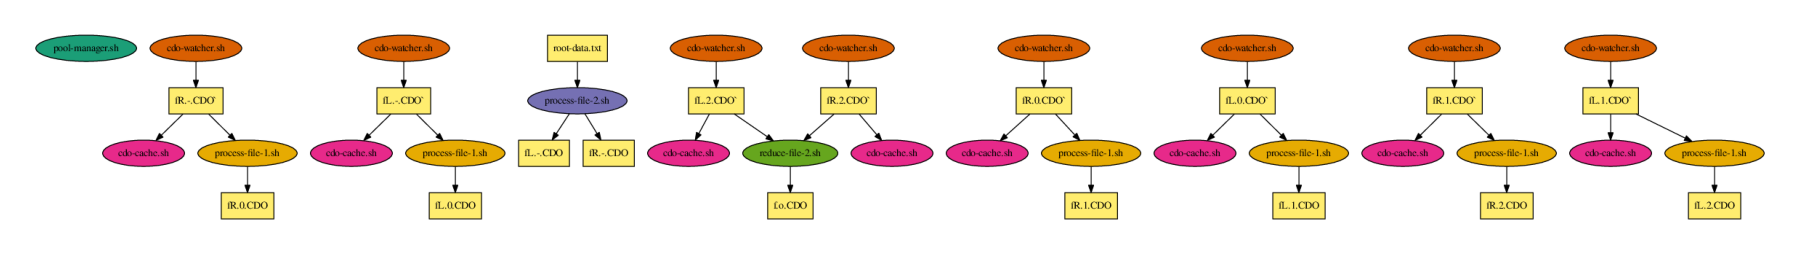

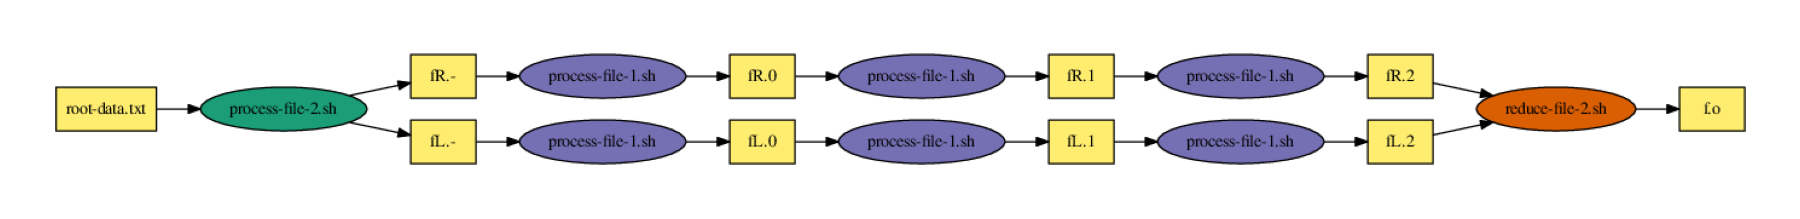

In [8]:
# ---------------------------------------
# cdo_dependencies : false, CDOs are not matched between in/out so CDO consumers do not depend on producers, the DAG is split
#                  : true, CDOs behave like files and trigger dependencies
# display_files : true, files appear as nodes in the graph, otherwise not
# transitive_reduction : true - remove links that are superfluous - transitive, between job-job bypassing files
cdo_dependencies     = False
display_files        = True
transitive_reduction = True
left_right           = True

if os.path.isfile("pegasus.properties"):
    os.remove("pegasus.properties")
if os.path.isfile("sites.yml"):
    os.remove("sites.yml")

rco = ReplicaCatalog()
rcm = ReplicaCatalog()
#sco = build_site_catalog()    
#prp = build_properties()

# ---------------------------------------
# Generate workflows, one original, one maestro enabled
wfo = Workflow(name="demo-orig.yml")
wfm = Maestro_Workflow(cdo_dependencies, name="demo-maestro.yml")

build_transformation_catalog('regular', wfo)
build_transformation_catalog('regular', wfm)
    
# ---------------------------------------
# Convert workflow into nice DAG display
file1 = generate_demo_workflow(wfo, rco)
I1 = display_workflow(file1, transitive_reduction, display_files, left_right)

file2 = generate_demo_workflow(wfm, rcm)
I2 = display_workflow(file2, transitive_reduction, display_files, left_right and cdo_dependencies) # left_right)

# ---------------------------------------
# rename pdf files based on what options we used to generate the DAG pics
fstring  = "-cdo" if cdo_dependencies else ""
fstring += "-files" if display_files else ""
fstring += "-reduced" if transitive_reduction else ""
image_name1 = I1.replace('.dot.pdf', fstring + '.pdf')
image_name2 = I2.replace('.dot.pdf', fstring + '.pdf')
os.rename(I1, image_name1)
os.rename(I2, image_name2)

# ---------------------------------------
# read+convert PDFs into images
img_A = WImage(filename=image_name1)
img_B = WImage(filename=image_name2)

# ---------------------------------------
# figure size in inches optional
rcParams['figure.figsize'] = 32, 32
# ---------------------------------------
# display images in notebook
fig, ax = plt.subplots(1,1)
ax.imshow(img_B);
ax.set_axis_off()
fig, ax = plt.subplots(1,1)
ax.imshow(img_A);
ax.set_axis_off()

In [9]:
#wfo.plan(submit=True, sites=['local'], cleanup=False)\
wfo.plan(submit=True, cleanup=False)\
    .wait()\
    .analyze()\
    .statistics()

# while not finished:    
#     new_data = poll_pool_manager('any new data')
#     spawn thread ( wf2.plan(dag_for['new_data']))


2021.08.16 12:22:22.747 UTC:
2021.08.16 12:22:22.753 UTC:   -----------------------------------------------------------------------
2021.08.16 12:22:22.758 UTC:   File for submitting this DAG to HTCondor           : demo-orig.yml-0.dag.condor.sub
2021.08.16 12:22:22.764 UTC:   Log of DAGMan debugging messages                 : demo-orig.yml-0.dag.dagman.out
2021.08.16 12:22:22.769 UTC:   Log of HTCondor library output                     : demo-orig.yml-0.dag.lib.out
2021.08.16 12:22:22.774 UTC:   Log of HTCondor library error messages             : demo-orig.yml-0.dag.lib.err
2021.08.16 12:22:22.780 UTC:   Log of the life of condor_dagman itself          : demo-orig.yml-0.dag.dagman.log
2021.08.16 12:22:22.785 UTC:
2021.08.16 12:22:22.790 UTC:   -no_submit given, not submitting DAG to HTCondor.  You can do this with:
2021.08.16 12:22:22.801 UTC:   -----------------------------------------------------------------------
2021.08.16 12:22:23.889 UTC:   Your database is compatible with Peg

[#########################] 100.0% ..Success (Unready: 0, Completed: 29, Queued: 0, Running: 0, Failed: 0))


In [10]:
I3 = display_workflow('../montage-v3/data/montage-workflow.yml', True, True)

# figure size in inches optional
rcParams['figure.figsize'] = 128,128

# read images
img_A = mpimg.imread(I3)
#img_B = mpimg.imread(I2)

# display images
fig, ax = plt.subplots(1,1)
ax.imshow(img_A);
#ax[1].imshow(img_B);

TypeError: display_workflow() missing 1 required positional argument: 'leftright'

In [ ]:
# display methods of something
# pprint.pprint(dir(wf))

# display args of function
# inspect.getfullargspec(wf.add_jobs)

In [ ]:
with open(workflow_file) as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    workflow_yaml = yaml.load(file, Loader=yaml.FullLoader)

g_yaml = nx.read_yaml(workflow_file)

g = nx.DiGraph()
nodes = [k['id'] for k in g_yaml['jobs']]
print('Nodes = ', nodes)
g.add_nodes_from(nodes)

# build a list of edges from each node to each child
for v in g_yaml['jobDependencies']:
    clist = [ [v['id'], c] for c in v["children"] ]
    g.add_edges_from(clist)
        
#g.add_edges_from([[v['id'], v['children']] for v in g_yaml['jobDependencies']])
top = nx.bipartite.sets(g)[0]
pos = nx.bipartite_layout(g, top)
#pos = nx.planar_layout(g)
nx.draw_networkx(g, node_shape='o', pos = pos)
    
#for key, value in G['jobDependencies']:
#    print(key, ":", value)
    
#print("\n")

#pprint.pprint(G)


In [ ]:
display_files        = True
transitive_reduction = True
left_right           = True

mv3 = "../montage-v3/data/montage-maestro-workflow.yml" 
I1 = display_workflow(mv3, transitive_reduction, display_files, left_right and cdo_dependencies) 

# ---------------------------------------
# rename pdf files based on what options we used to generate the DAG pics
fstring  = "-cdo" if cdo_dependencies else ""
fstring += "-files" if display_files else ""
fstring += "-reduced" if transitive_reduction else ""
image_name1 = I1.replace('.dot.pdf', fstring + '.pdf')
os.rename(I1, image_name1)

# ---------------------------------------
# read+convert PDFs into images
img_A = WImage(filename=image_name1)

# ---------------------------------------
# figure size in inches optional
rcParams['figure.figsize'] = 64, 64
# ---------------------------------------
# display images in notebook
fig, ax = plt.subplots(1,1)
ax.imshow(img_A);
ax.set_axis_off()
